In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import keras
from keras.models import load_model
from sklearn import preprocessing
from scipy.ndimage import zoom

Using TensorFlow backend.


In [2]:
cv2.__version__

'4.2.0'

In [3]:
input_f = 'data/robot_parcours_1.avi'
output_f = 'data/output.avi'

In [4]:
# returns the minimum distance between two points of two contours
def contours_dist(c1, c2):
    return cdist(c1.squeeze(), c2.squeeze()).min()

# returns the center of a contour
def center(contour):
    
    M = cv2.moments(contour)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return (cX, cY)

# preprocess images from the original image to the nn input
def preprocess_img(sub_img):
    size = 28
    sub_img = cv2.cvtColor(sub_img, cv2.COLOR_BGR2GRAY)
    
    sub_img = cv2.resize(sub_img, (size, size), interpolation = cv2.INTER_AREA)
    sub_img = sub_img.astype('float32')
    sub_img /= 255
    sub_img = 1-sub_img
    sub_img[sub_img < sub_img.mean()] = 0
    sub_img = preprocessing.MinMaxScaler().fit_transform(sub_img)
    sub_img = np.reshape(sub_img, (1, size, size,1))
    sub_img = clipped_zoom(sub_img, 1.3)
    return sub_img

def find_robot(img):
    kernel = np.ones((5,5),np.uint8)
    reds = img[:, :, 0]
    blues = img[:, :, 1]
    greens = img[:, :, 2]

    mask = np.array((blues < 100) & (greens < 100) & (reds > 100), dtype=np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    contours, hierarchy = cv2.findContours(mask,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

    areas = [cv2.contourArea(c) for c in contours]
    max_index = np.argmax(areas)
    contour = contours[max_index]
    
    return center(contour)

def draw_robot_pos(img, pos):
    for p in pos:
        img = cv2.drawMarker(img, p, (0, 255, 0), thickness=1)
    return img

def robot_on_char(robot_p, char_centers):
    min_dist = min(cdist([robot_p], char_centers).flatten())
    if min_dist < 30:
        return np.argmin(cdist([robot_p], char_centers).flatten())
    

def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

    
"""
Encoding: plus = 0, minus = 1, div = 2, times = 3, egal = 4
"""
pred_to_operator = {0: '+', 1: '-', 2: '/', 3: '*', 4: '='}

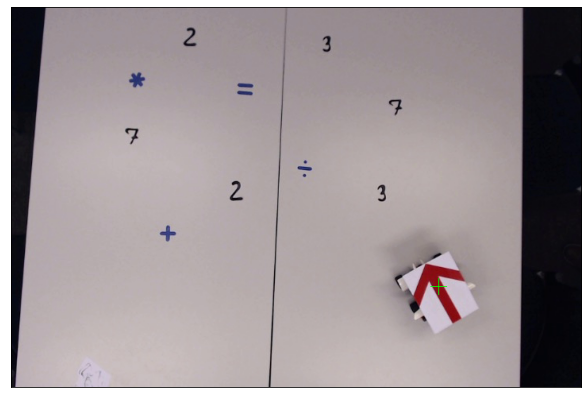

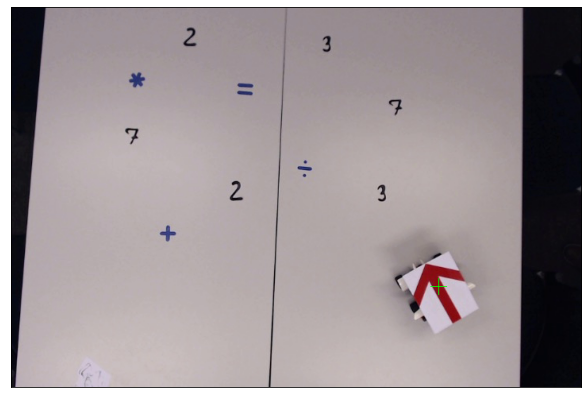

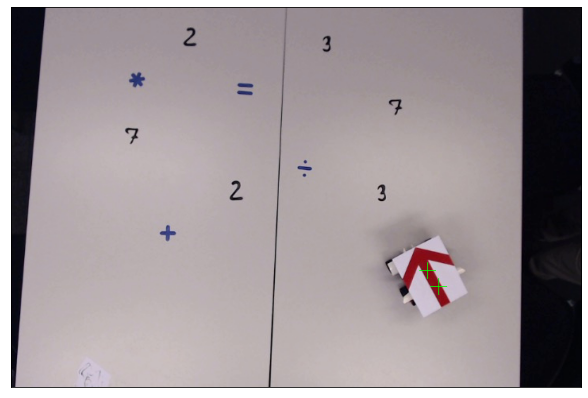

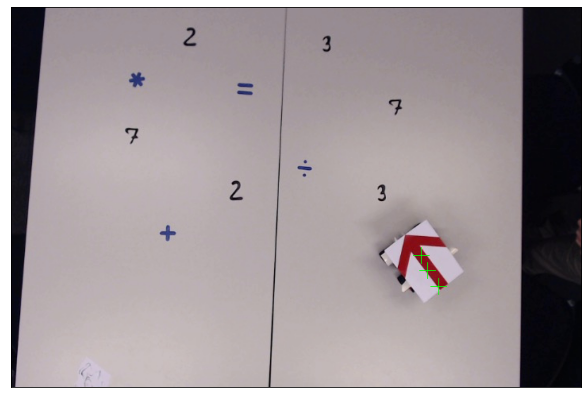

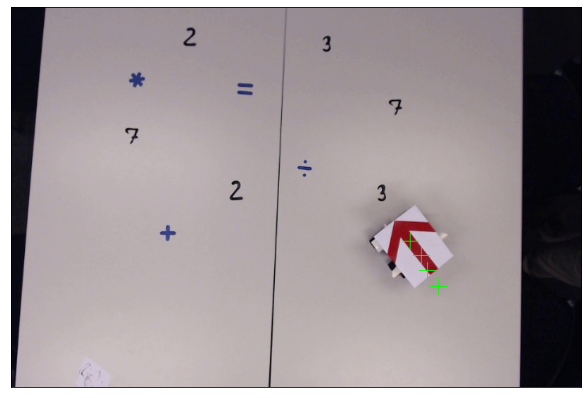

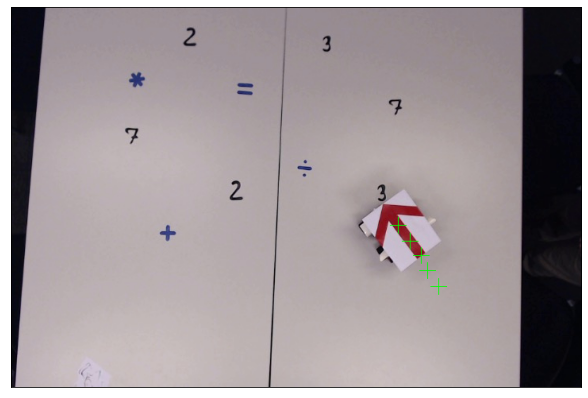

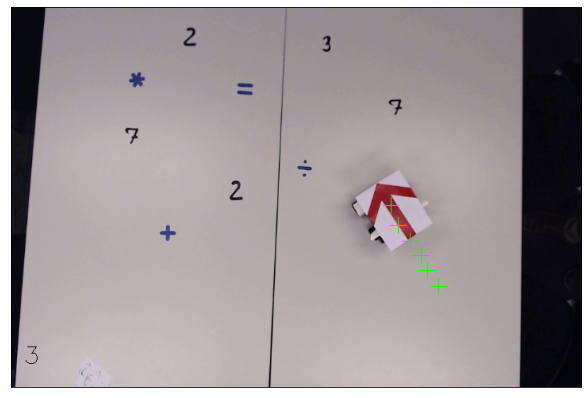

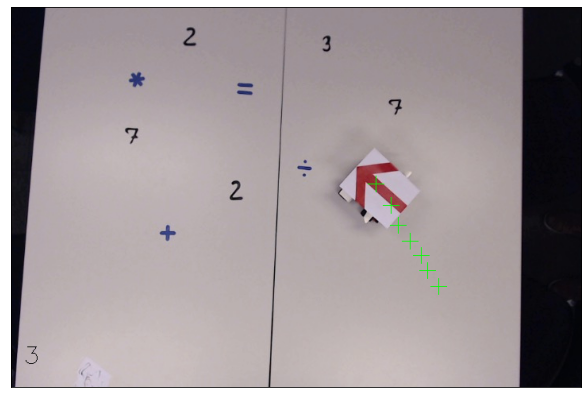

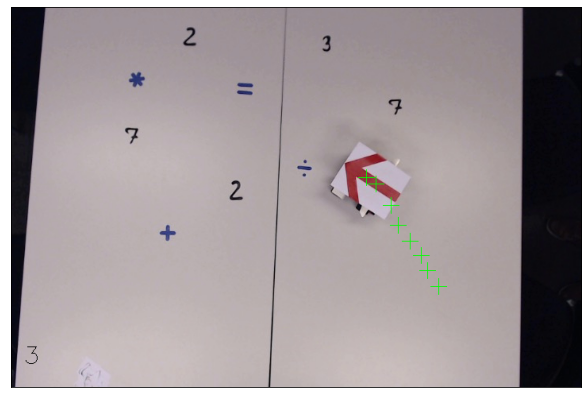

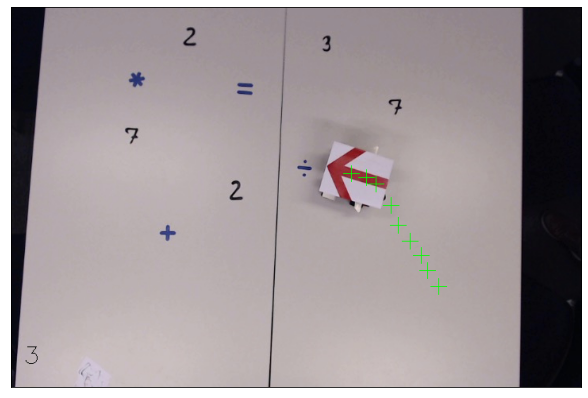

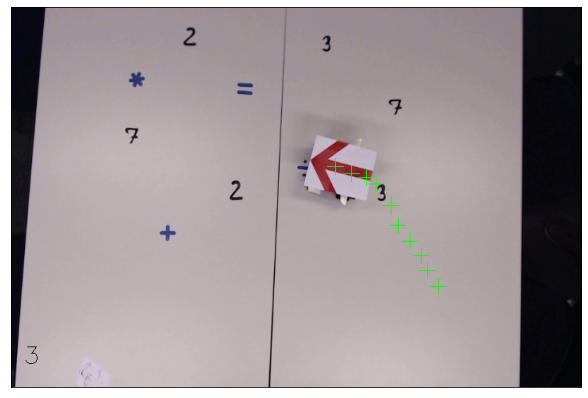

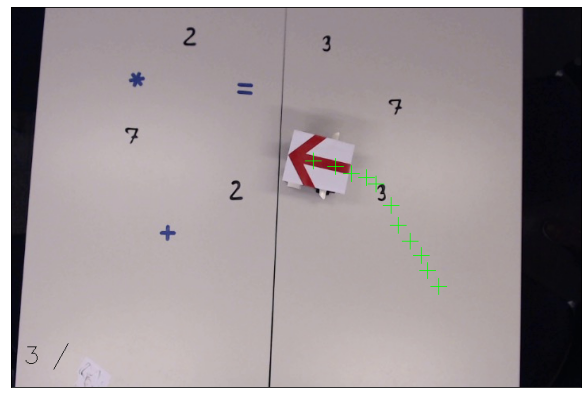

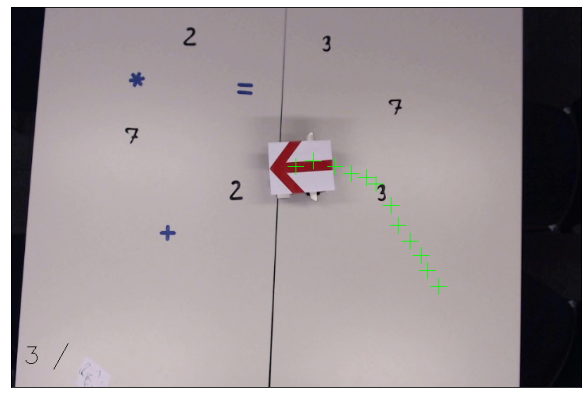

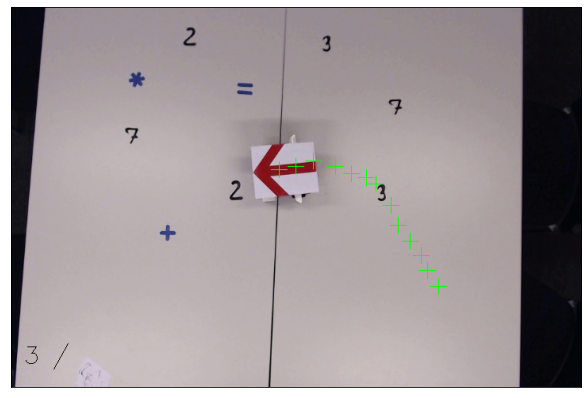

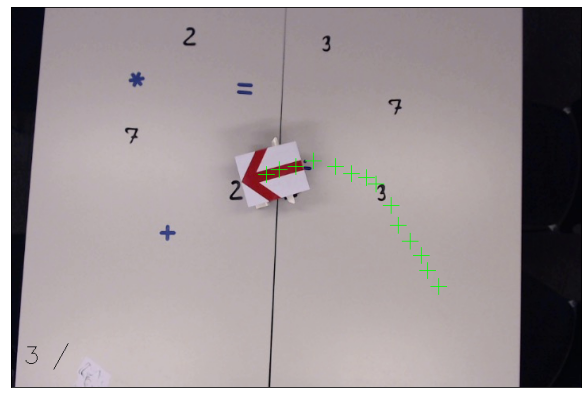

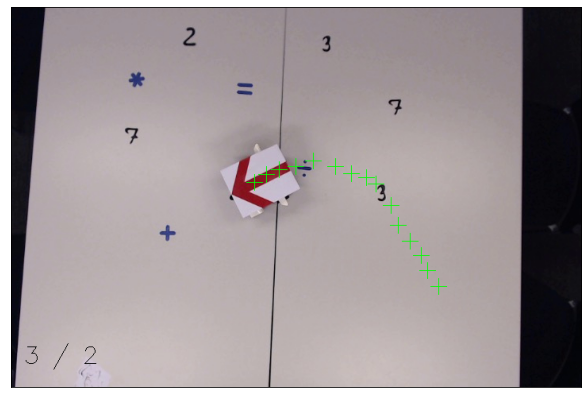

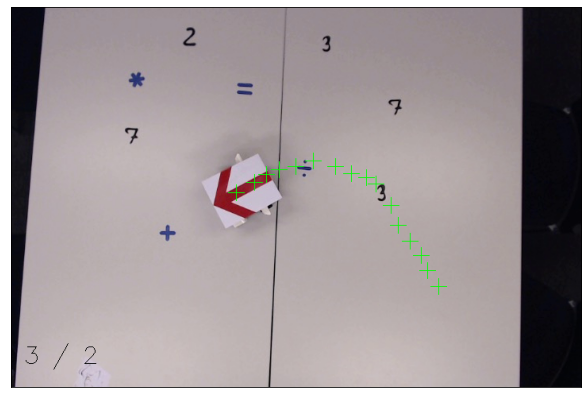

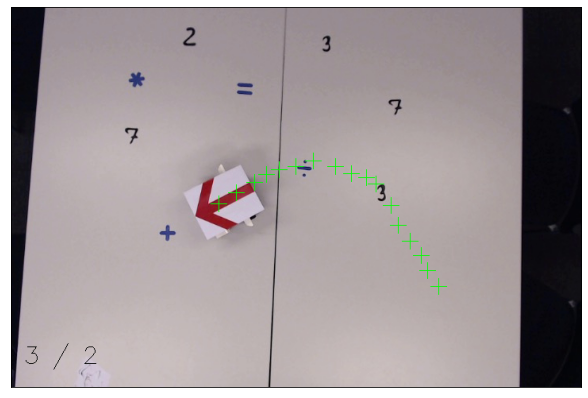

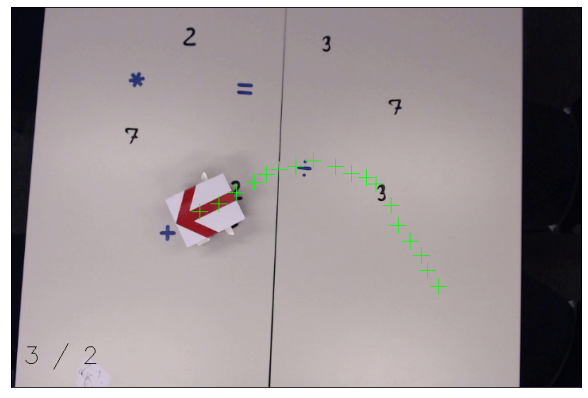

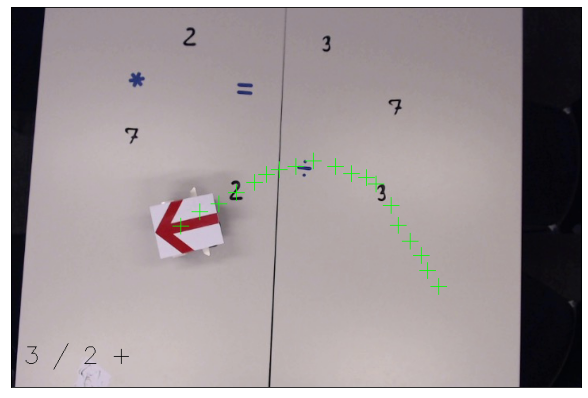

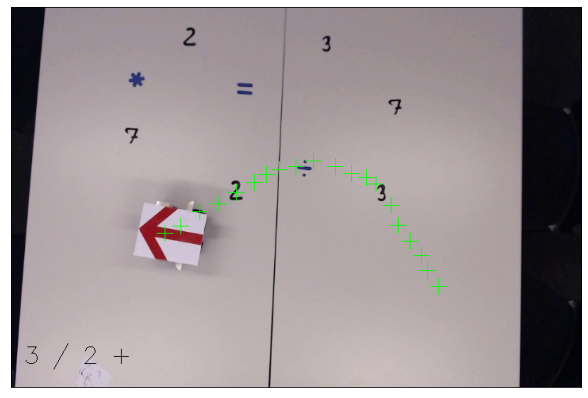

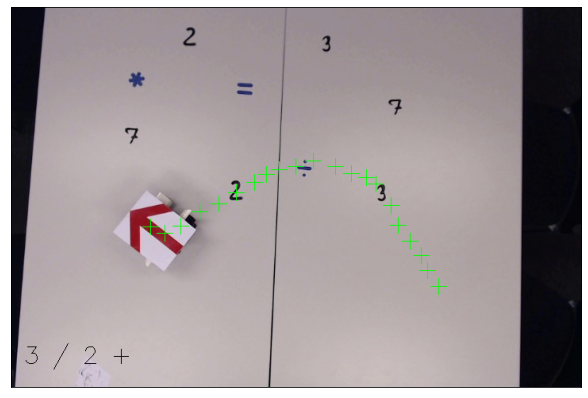

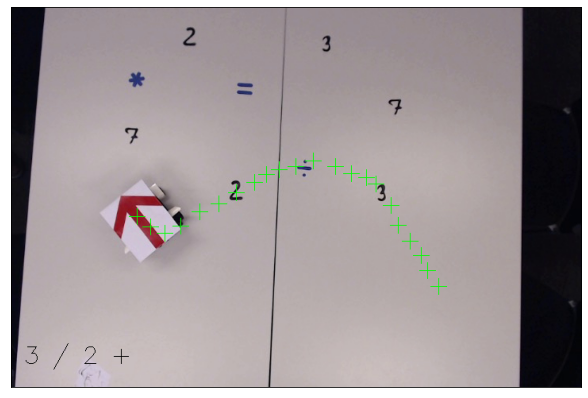

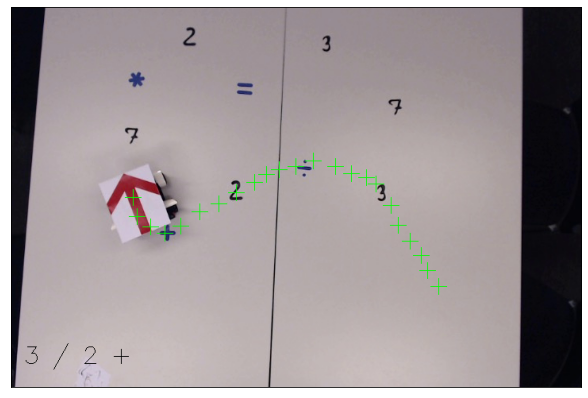

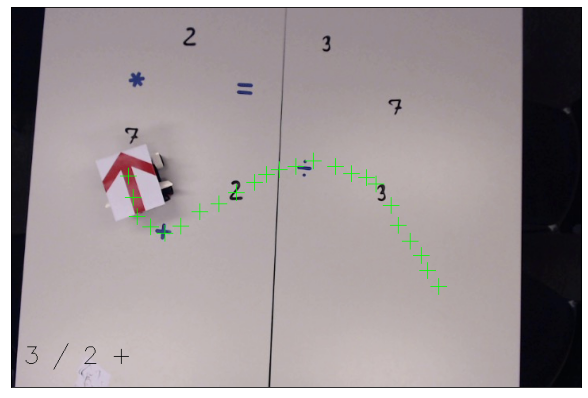

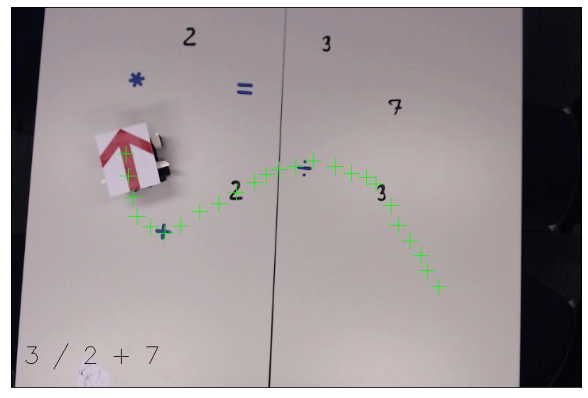

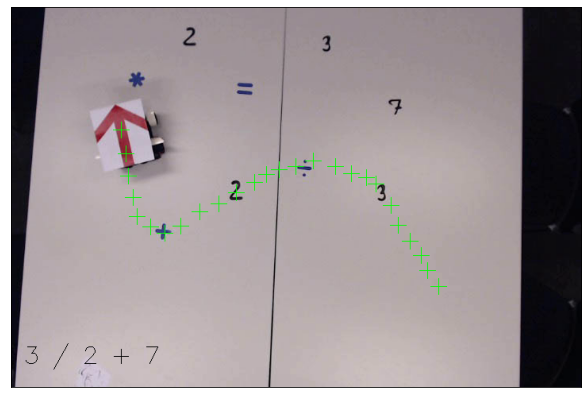

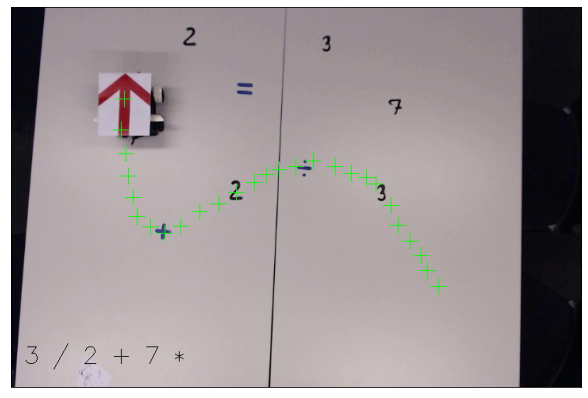

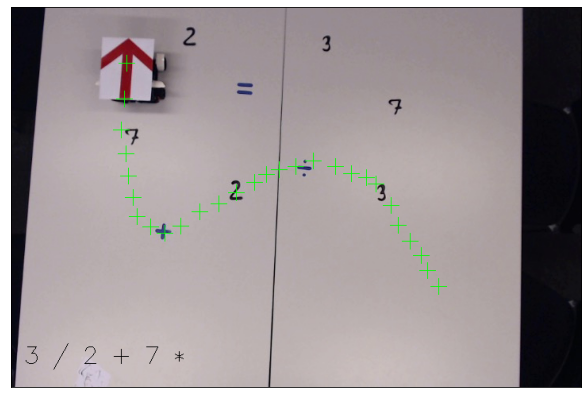

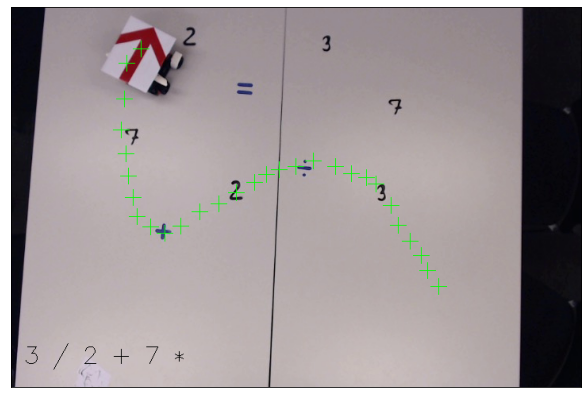

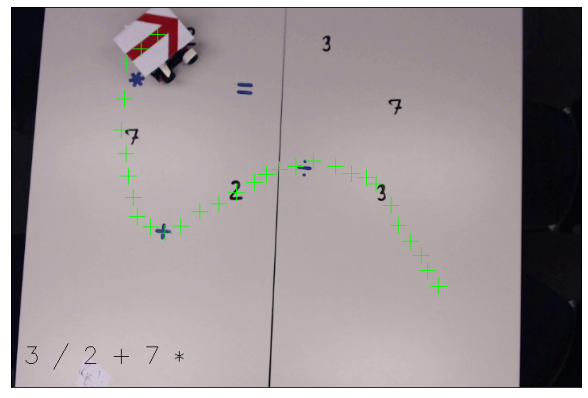

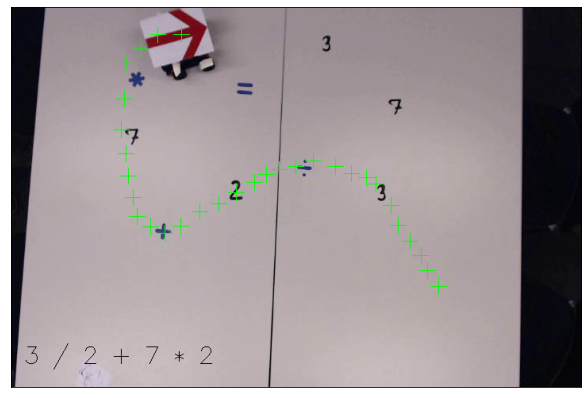

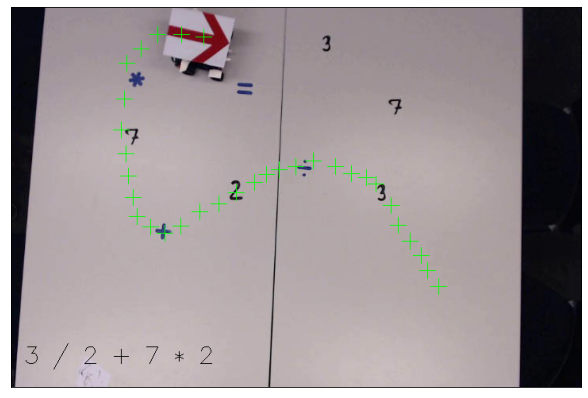

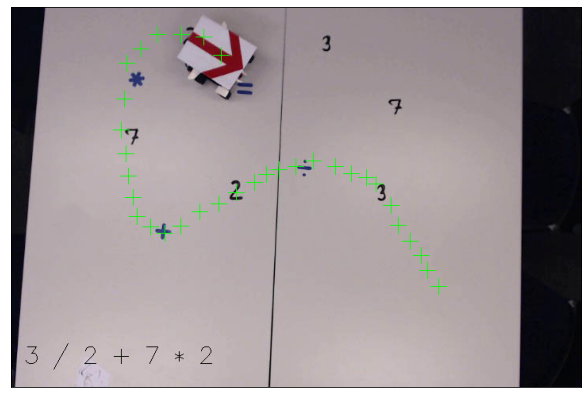

15.5


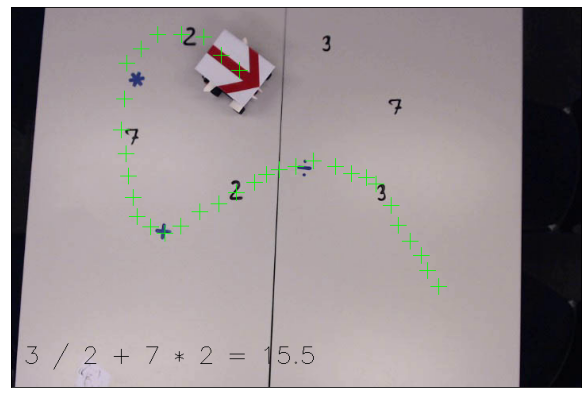

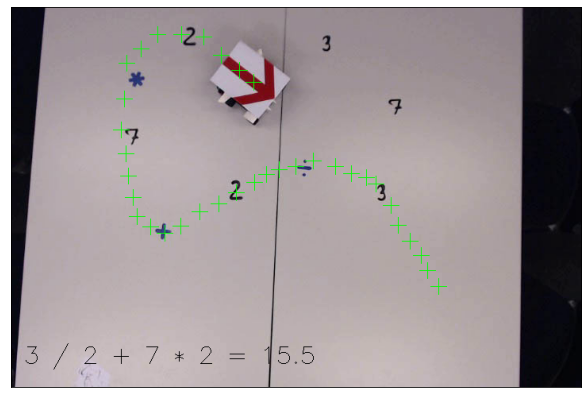

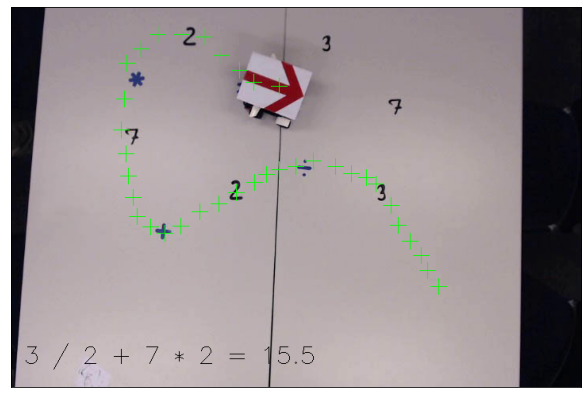

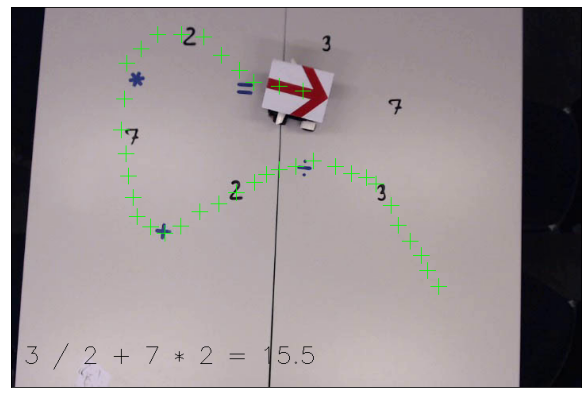

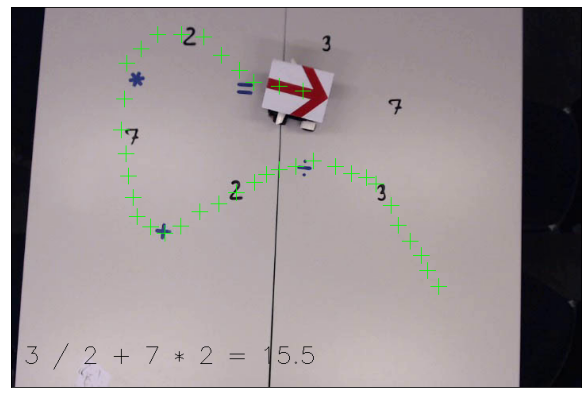

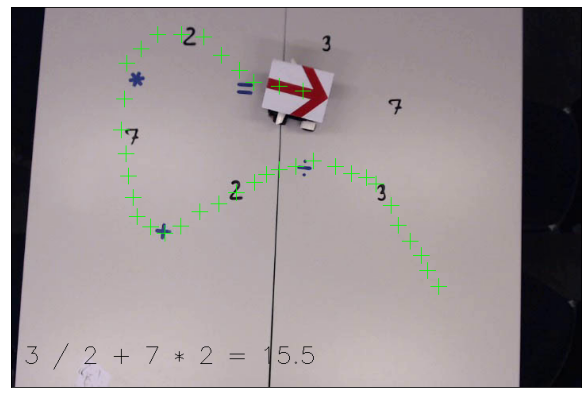

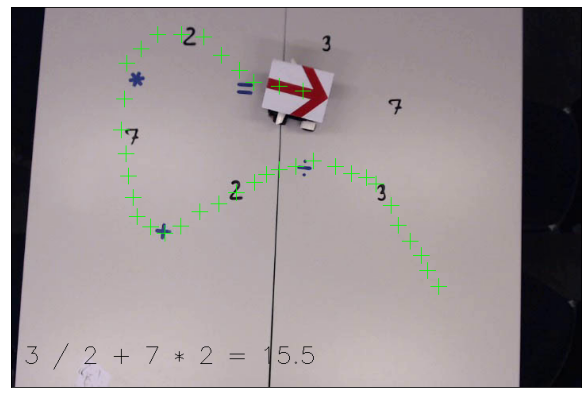

In [5]:
# Part 1: read all characters on the board

cap = cv2.VideoCapture(input_f)

success, frame0 = cap.read(0)

frame0_gray = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(frame0_gray, 90, 110, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

characters = []

while len(contours) > 0:
    
    shape = contours.pop(0)
    
    while contours and min([contours_dist(shape, c) for c in contours]) < 20:
        closest = np.argmin([contours_dist(shape, c) for c in contours])
        shape = np.concatenate([shape, contours.pop(closest)])    
    
    if (cv2.contourArea(shape) > 50) and (cv2.contourArea(shape) < 300):
        characters.append(shape)
        
# Part 2: map to all the characters a prediction for being an operator and a digit

digit_classifier = load_model('digit_classifier.h5')
operator_classifier = load_model('operator_classifier.h5')

char_centers = []
index_to_char = {}

for i, c in enumerate(characters):
    # compute the center of the contour
    cX, cY = center(c)
    char_centers.append([cX, cY])
    size = 40
    
    sub_img = frame0[int(cY-size/2):int(cY+size/2), int(cX-size/2):int(cX+size/2)]
    img = preprocess_img(sub_img)
    pred_o = np.argmax(operator_classifier.predict(img))
    pred_d = np.argmax(digit_classifier.predict(img))
        
    index_to_char[i] = {True: str(pred_d), False: pred_to_operator[pred_o]}

    
# Part 3: for each image, test if the robot is stepping on a character and update the equation

out_frames = []
robot_pos = []

is_digit = True
equation = ''
previous_detected = None
equation_pos = (0, frame0.shape[0]-30)

while success:
    success, img = cap.read(500)
    if success:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        robot_pos.append(find_robot(img))
        draw_robot_pos(img, robot_pos)
        
        detection = robot_on_char(robot_pos[-1], char_centers)

        if (detection is not None) and detection != previous_detected:
            
            equation += ' ' + index_to_char[detection][is_digit]
            
            if index_to_char[detection][is_digit] == '=':
                print(eval(equation[:-2]))
                equation += ' ' + str(eval(equation[:-2]))
                
            is_digit = not is_digit
            previous_detected = detection
            
        img = cv2.putText(img, equation, equation_pos, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0))
        fig, ax = plt.subplots(figsize=(15, 7))
        ax.imshow(img)
        ax.set_xticks([]), ax.set_yticks([])
        ax.axis([0, img.shape[1], img.shape[0], 0])
        plt.show()
        
        out_frames.append(img)


writer = cv2.VideoWriter(output_f, cv2.VideoWriter_fourcc(*'MJPG'), 2, (frame0.shape[1],frame0.shape[0]))

for frame in out_frames:
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    writer.write(frame)

writer.release()

In [ ]:
char_imgs = []
to_draw = frame0.copy()

i = 0
for c in characters:
    # compute the center of the contour
    M = cv2.moments(c)
    cX = M["m10"] / M["m00"]
    cY = M["m01"] / M["m00"]
    #print(str(i), ':', (cX, cY))
    size = 40
    
    sub_img = frame0[int(cY-size/2):int(cY+size/2), int(cX-size/2):int(cX+size/2)]
    char_imgs.append(sub_img)
    cv2.rectangle(to_draw, (int(cX-size/2), int(cY-size/2)), (int(cX+size/2), int(cY+size/2)), (0, 0, 255), 3)
    
    img = preprocess_img(sub_img)
    pred_o = np.argmax(operator_classifier.predict(img))
    pred_d = np.argmax(digit_classifier.predict(img))
    cv2.putText(to_draw, str(pred_d), (int(cX), int(cY)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0))
    cv2.putText(to_draw, str(pred_o), (int(cX)-20, int(cY)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0))

    i += 1

fig, ax = plt.subplots(figsize=(15, 7))
ax.imshow(cv2.cvtColor(to_draw, cv2.COLOR_BGR2RGB))
ax.set_xticks([]), ax.set_yticks([])
plt.show()

In [ ]:
preprocessing.MinMaxScaler().fit_transform(prep_img.squeeze()).mean()

In [ ]:
for img in char_imgs:
    
    print(img.shape)
    prep_img = preprocess_img(img)
    print('Digit:', np.argmax(digit_classifier.predict(prep_img)))
    print('Operator:', np.argmax(operator_classifier.predict(prep_img)))
    print(operator_classifier.predict(prep_img))
    fig, ax = plt.subplots(figsize=(15, 7))

    ax.imshow(prep_img.squeeze(), cmap = 'gray')
    ax.set_xticks([]), ax.set_yticks([])
    plt.show()

In [ ]:
import skimage.io
import os

operator = skimage.io.imread(os.path.join('data/original_operators.png'))
plus = operator[16:316, 0:300, :]
egal = operator[:, 350:650,:]
minus = operator[:, 700:1000,:]
div = operator[:, 1080:1380,:]
times = operator[:, 1450:1750,:]

operators = [plus, minus, div, times, egal]

In [ ]:
from sklearn import preprocessing
def preprocess_img(sub_img):
    size = 28
    #sub_img = cv2.cvtColor(sub_img, cv2.COLOR_BGR2GRAY)
    
    #sub_img = cv2.resize(sub_img, (size, size), interpolation = cv2.INTER_AREA)
    sub_img = sub_img.astype('float32')
    sub_img /= 255
    sub_img = 1-sub_img
    sub_img[sub_img < sub_img.mean()] = 0
    sub_img = preprocessing.MinMaxScaler().fit_transform(sub_img)
    #sub_img = np.reshape(sub_img, (1, size, size,1))
    return sub_img

In [ ]:
import cv2 as cv

dataset = []

for img in [plus, minus, div, times, egal]:
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    resized = cv.resize(gray, (size, size), interpolation = cv.INTER_AREA)

    for i in range(100):
        size = 28
        #rotated = ndimage.rotate(resized, np.random.randint(360), reshape=False, mode='constant', cval=255, order=5, prefilter=False)
        rotated = resized
        T = np.concatenate([np.identity(2), np.random.uniform(low=-2, high=2, size=(2,1))], axis=1)
        translated = cv.warpAffine(rotated, T, rotated.shape, borderValue=255)
        noise = np.random.normal(0,5,(28,28))
        g_blur = cv.GaussianBlur(translated, (3, 3), 10, 10)
        out = g_blur + noise
        
        out = preprocess_img(out)
        
        dataset.append(out)
        
dataset = np.array(dataset)
print(dataset.shape)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6, 6))
ax[0].imshow(dataset[12], cmap='gray')
ax[1].imshow(dataset[333], cmap='gray')
plt.show()

In [ ]:
img1 = preprocess_img(char_imgs[0]).squeeze()
img2 = preprocess_img(char_imgs[7]).squeeze()

zm1 = clipped_zoom(img2, 1.3)
zm1